<a href="https://colab.research.google.com/github/Wisley1/SWW12/blob/main/FirstStep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [134]:
# @title data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from google.colab import drive
drive.mount('/content/drive')

valid = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SWW12/US_patents_1976-Sep2016_1product_reactions_yield_ok_cropped_data_valid.csv', sep="\t", index_col=0)
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SWW12/US_patents_1976-Sep2016_1product_reactions_yield_ok_cropped_data_train.csv',sep="\t", index_col=0)
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SWW12/US_patents_1976-Sep2016_1product_reactions_yield_ok_cropped_data_test.csv',sep="\t", index_col=0)

#valid.columns = ['Number', 'myID', 'Source', 'Target', 'CanonicalizedReaction', 'OriginalReaction', 'Yield']
#train.columns = ['Number', 'CanonicalizedReaction', 'Yield']
#test.columns = ['Number', 'myID', 'Source', 'Target', 'CanonicalizedReaction', 'OriginalReaction', 'Yield']

train = train.assign(dataset='train')
test = test.assign(dataset='test')
valid = valid.assign(dataset='valid')

frames = [train, test, valid]
df = pd.concat(frames)
df = df.drop(columns=['myID', 'Source', 'Target', 'OriginalReaction'])
df.head()

df_mid = df
df_mid = df_mid['CanonicalizedReaction'].str.split('>', expand=True)

df['react'] = df_mid.iloc[:, 0]
df['products'] = df_mid.iloc[:, 2]
print(df.shape)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(526468, 5)


,CanonicalizedReaction,Yield,dataset,react,products
11,CCOC(=O)CC1(O)Cc2ccccc2N(C)c2ccc(SCC)cc21>CCO....,82.0,train,CCOC(=O)CC1(O)Cc2ccccc2N(C)c2ccc(SCC)cc21,CCOC(=O)C=C1Cc2ccccc2N(C)c2ccc(SCC)cc21
12,CCOC(=O)C=C1Cc2ccccc2N(C)c2ccc(SCC)cc21>CCO.Cl...,78.1,train,CCOC(=O)C=C1Cc2ccccc2N(C)c2ccc(SCC)cc21,CCSc1ccc2c(c1)C(CC(=O)O)=Cc1ccccc1N2C
14,CCSc1ccc2c(c1)C(CC(=O)N(C)C)=Cc1ccccc1N2C>C1CC...,82.1,train,CCSc1ccc2c(c1)C(CC(=O)N(C)C)=Cc1ccccc1N2C,CCSc1ccc2c(c1)C(CCN(C)C)=Cc1ccccc1N2C
23,CC(C)(C)NNC(C)(C#N)C1CC1>BrBr.ClCCl.O>CC(C)(C)...,81.9,train,CC(C)(C)NNC(C)(C#N)C1CC1,CC(C)(C)N=NC(C)(C#N)C1CC1
24,CC(C)(C)NNC(C)(C#N)C1CC1.O=C1CCCCCCC1>CC(=O)C1...,100.0,train,CC(C)(C)NNC(C)(C#N)C1CC1.O=C1CCCCCCC1,CC(C)(C)NNC1(C#N)CCCCCCC1


smiles делить по стрелочке
реагент условия продукт
до точки реактант после точки реагент

реактант - молекула органическая с атомами углерода, которая участвует во взаимодействии
реагент - едкий натр участвует но не меняется

посчитать сколько реактантов (1,2,3) в процентах

условия удаляем

распределение выхода

In [135]:
df['num_dots'] = df['react'].str.count('\.')

In [136]:
df['num_dots'].value_counts(normalize=True)*100

1    68.190089
0    25.103710
2     5.418943
3     1.038050
4     0.211979
5     0.031531
6     0.004369
7     0.000950
8     0.000380
Name: num_dots, dtype: float64

In [137]:
# @title distribution
def distribution(dt, col):
  x = str(col)
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16, 8), sharex=False, sharey=False)
  fig.suptitle(x, fontsize=20)

  ax[0].title.set_text('distribution')
  variable = dt[x].fillna(dt[x].mean())
  sns.histplot(variable, kde=True, element='step', fill=True, alpha=.5, ax=ax[0])
  des = dt[x].describe()
  ax[0].axvline(des["25%"], ls='--')
  ax[0].axvline(des["mean"], ls='--')
  ax[0].axvline(des["75%"], ls='--')
  ax[0].grid(True)
  des = round(des, 2).apply(lambda x: str(x))
  box = '\n'.join(("min: "+des["min"], "25%: "+des["25%"], "mean: "+des["mean"], "75%: "+des["75%"], "max: "+des["max"]))
  ax[0].text(0.25, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1))

  ax[1].title.set_text('outliers')
  tmp_dtf = pd.DataFrame(dt[x])
  tmp_dtf.boxplot(column=x, ax=ax[1])
  print(plt.show())

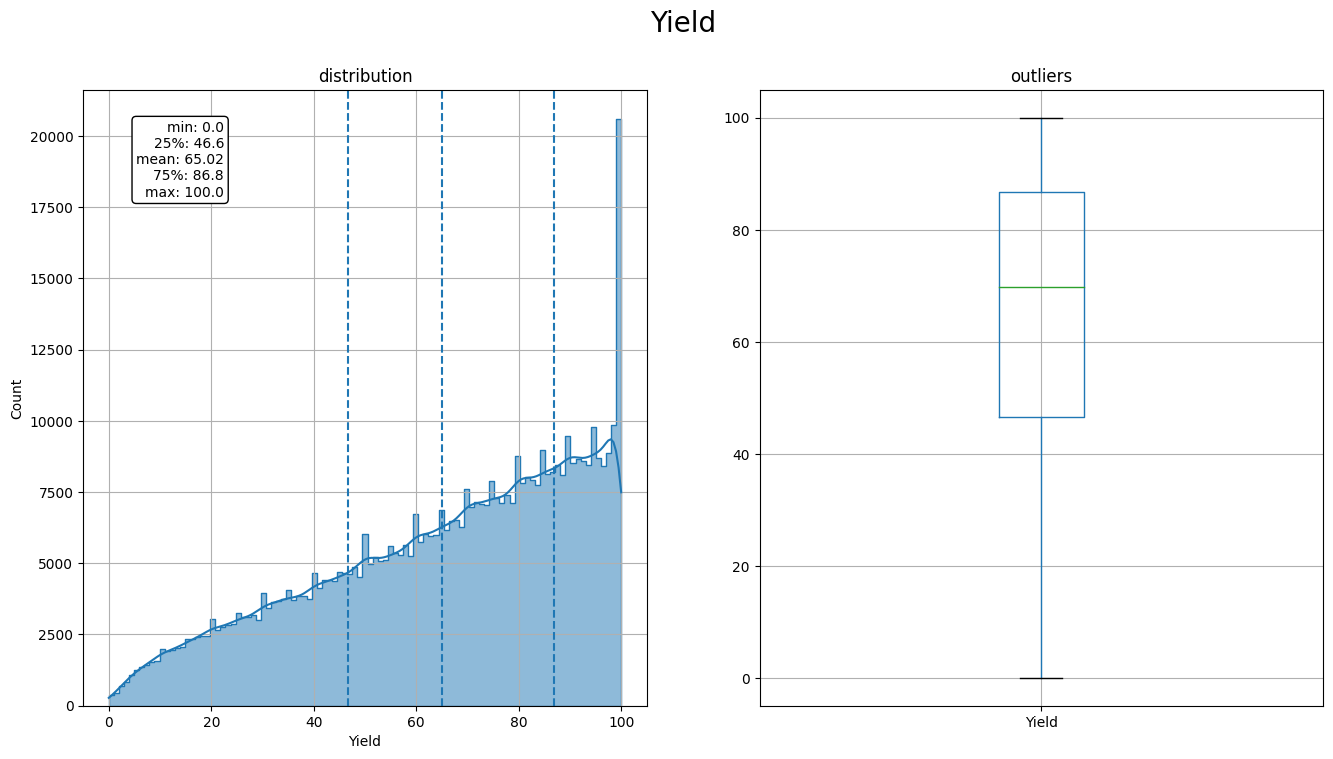

None


In [138]:
distribution(df, 'Yield')

In [139]:
print(df.shape)
df = df.loc[((df['num_dots'] == 0) | (df['num_dots' ] == 1))]


df['part1'] = df['react'].str.split('\.').str[0]
df['part2'] = df['react'].str.split('\.').str[-1]

df.loc[df['num_dots'] == 0, 'part2'] = np.nan
print(df.shape)

(526468, 6)
(491162, 8)


In [140]:
df.head()

,CanonicalizedReaction,Yield,dataset,react,products,num_dots,part1,part2
11,CCOC(=O)CC1(O)Cc2ccccc2N(C)c2ccc(SCC)cc21>CCO....,82.0,train,CCOC(=O)CC1(O)Cc2ccccc2N(C)c2ccc(SCC)cc21,CCOC(=O)C=C1Cc2ccccc2N(C)c2ccc(SCC)cc21,0,CCOC(=O)CC1(O)Cc2ccccc2N(C)c2ccc(SCC)cc21,NaN
12,CCOC(=O)C=C1Cc2ccccc2N(C)c2ccc(SCC)cc21>CCO.Cl...,78.1,train,CCOC(=O)C=C1Cc2ccccc2N(C)c2ccc(SCC)cc21,CCSc1ccc2c(c1)C(CC(=O)O)=Cc1ccccc1N2C,0,CCOC(=O)C=C1Cc2ccccc2N(C)c2ccc(SCC)cc21,NaN
14,CCSc1ccc2c(c1)C(CC(=O)N(C)C)=Cc1ccccc1N2C>C1CC...,82.1,train,CCSc1ccc2c(c1)C(CC(=O)N(C)C)=Cc1ccccc1N2C,CCSc1ccc2c(c1)C(CCN(C)C)=Cc1ccccc1N2C,0,CCSc1ccc2c(c1)C(CC(=O)N(C)C)=Cc1ccccc1N2C,NaN
23,CC(C)(C)NNC(C)(C#N)C1CC1>BrBr.ClCCl.O>CC(C)(C)...,81.9,train,CC(C)(C)NNC(C)(C#N)C1CC1,CC(C)(C)N=NC(C)(C#N)C1CC1,0,CC(C)(C)NNC(C)(C#N)C1CC1,NaN
24,CC(C)(C)NNC(C)(C#N)C1CC1.O=C1CCCCCCC1>CC(=O)C1...,100.0,train,CC(C)(C)NNC(C)(C#N)C1CC1.O=C1CCCCCCC1,CC(C)(C)NNC1(C#N)CCCCCCC1,1,CC(C)(C)NNC(C)(C#N)C1CC1,O=C1CCCCCCC1
